# Data Wrangling

## Libraries

### Install

In [4]:
#!pip install missingno

### Imports

In [1]:
#Import the relevant modules
import os
import glob

import pandas as pd
import numpy as np

import datetime as dt
import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pathlib import Path

import missingno as msno


## Read Data

In [2]:
# Change directory one step back and save as the root directory
ROOT_DIR = os.path.normpath(os.getcwd() + os.sep + os.pardir)

#Define start and end dates
fromDate = '2000-01-01'
toDate = '2023-04-15'

In [3]:
def get_file_name(file_name):
    name_ext = file_name.split("\\")[-1]
    name = name_ext.split(".")[0]
    return name

In [4]:
#Provide the name of CSV datasets
my_datasets_csv = [
    'eia_data.csv',
    'fred_data.csv',
    'offline_data.csv']

In [5]:
# Change directory one step back and save as the root directory
ROOT_DIR = os.path.normpath(os.getcwd() + os.sep + os.pardir)

# Change direcotry to the 'data\interim' folder
path = ROOT_DIR + '\\data\\interim\\'

#Get the full file names (including directory)
for i in range(len(my_datasets_csv)):
    my_datasets_csv[i] = path + my_datasets_csv[i]

In [6]:
# Initialize list; this is the final list that will store all the data from the json pull. 
data = []

# loop over the list of csv files
for f in my_datasets_csv:
    #print file name
    print(get_file_name(f))
    
    #read the csv file into a new dataframe
    new_data = pd.read_csv(f)
    
    #drop the header
    new_data = new_data.drop(columns = ['Unnamed: 0'])
    
    #filter using from-to-dates
    new_data = new_data.loc[(new_data['Date'] >= fromDate) & (new_data['Date'] <= toDate)]
    
    #print the dataframe shape
    print(new_data.shape)

    data.append(new_data)

eia_data
(280, 20)
fred_data
(279, 8)
offline_data
(280, 7)


## Merge dataframes

In [7]:
#find the df with longest dataseries
max_val = data[0].shape[0]
max_idx = 0

for i in range(len(data)):    
    size = size = data[i].shape[0]
    if size>max_val:
        max_val = size
        max_idx = i

In [8]:
#initiate the df with the the longest timeseries
df = data[max_idx]
for i in range(0, len(data)):
    if i != max_idx:
        df_temp = data[i]
        df = pd.merge_ordered(df, df_temp, on = 'Date')

df.set_index('Date', drop=True, inplace=True)

In [9]:
#sort data
df.sort_index(axis = 0, inplace = True)

#### Set Date format for index


In [10]:
#import datetime

df.index = pd.to_datetime(df.index)

## Explore features

### Check data types and counts

In [11]:
df.shape

(280, 32)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 280 entries, 2000-01-01 to 2023-04-01
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   WTIPUUS          280 non-null    float64
 1   COPR_OPEC        280 non-null    float64
 2   PAPR_NONOPEC     280 non-null    float64
 3   COPRPUS          280 non-null    float64
 4   PATC_OECD        280 non-null    float64
 5   PATC_NON_OECD    280 non-null    float64
 6   CICPIUS          280 non-null    float64
 7   WPCPIUS          280 non-null    float64
 8   WP57IUS          280 non-null    float64
 9   ZOMNIUS          280 non-null    float64
 10  PASC_OECD_T3     244 non-null    float64
 11  PASXPUS          280 non-null    float64
 12  COSQPUS          280 non-null    float64
 13  COSXPUS          280 non-null    float64
 14  MGWHUUS          280 non-null    float64
 15  DSWHUUS          280 non-null    float64
 16  BREPUUS          280 non-null    float64
 1

### Display head and tail of data

In [13]:
#head of data records
display(df.head(5).round(1).T)

Date,2000-01-01,2000-02-01,2000-03-01,2000-04-01,2000-05-01
WTIPUUS,27.3,29.4,29.8,25.7,28.8
COPR_OPEC,26.0,26.7,26.6,27.5,28.0
PAPR_NONOPEC,46.9,46.8,46.9,46.6,46.6
COPRPUS,5.8,5.9,5.9,5.9,5.8
PATC_OECD,47.2,50.2,49.4,46.3,47.3
PATC_NON_OECD,28.3,28.8,28.5,28.1,28.2
CICPIUS,1.7,1.7,1.7,1.7,1.7
WPCPIUS,1.3,1.3,1.3,1.3,1.3
WP57IUS,0.8,0.8,0.9,0.8,0.9
ZOMNIUS,92.0,92.3,92.9,93.5,93.6


In [14]:
#tail of data records
display(df.tail(5).round(1).T)

Date,2022-12-01,2023-01-01,2023-02-01,2023-03-01,2023-04-01
WTIPUUS,76.4,78.1,76.8,73.3,80.0
COPR_OPEC,28.8,28.3,28.5,28.6,28.5
PAPR_NONOPEC,65.7,66.9,67.1,67.2,67.3
COPRPUS,12.1,12.5,12.6,12.6,12.5
PATC_OECD,46.1,44.6,46.2,45.9,45.3
PATC_NON_OECD,54.8,53.5,55.1,54.6,54.6
CICPIUS,3.0,3.0,3.0,3.0,3.0
WPCPIUS,2.6,2.5,2.5,2.5,2.4
WP57IUS,2.9,2.7,2.7,2.6,2.7
ZOMNIUS,98.6,100.0,100.2,99.0,99.1


## Missing data

In [15]:
def count_missing(df):
    ''' Count the number of missing values .isnull() in each column well as the percentages 
    Call pd.concat() to form a single table df with 'count' and '%' columns'''
    
    missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
    missing.columns=['count', '%']
    missing = missing.loc[missing['count'] > 0]
    missing.sort_values(by='count', ascending = False)
    
    return missing

### Missing data statistics

In [16]:
#Count missing data
missing_stats = count_missing(df)
display(missing_stats)

,count,%
PASC_OECD_T3,36,12.857143
WORL,4,1.428571
RNGWHHD,1,0.357143
FEDFUNDS,1,0.357143
IGREA,2,0.714286
USACPIENGMINMEI,3,1.071429
EA19PIEAMI01GPM,5,1.785714
RTWEXBGS,73,26.071429
DEXUSEU,1,0.357143
GEPUCURRENT,4,1.428571


### Missing data plot

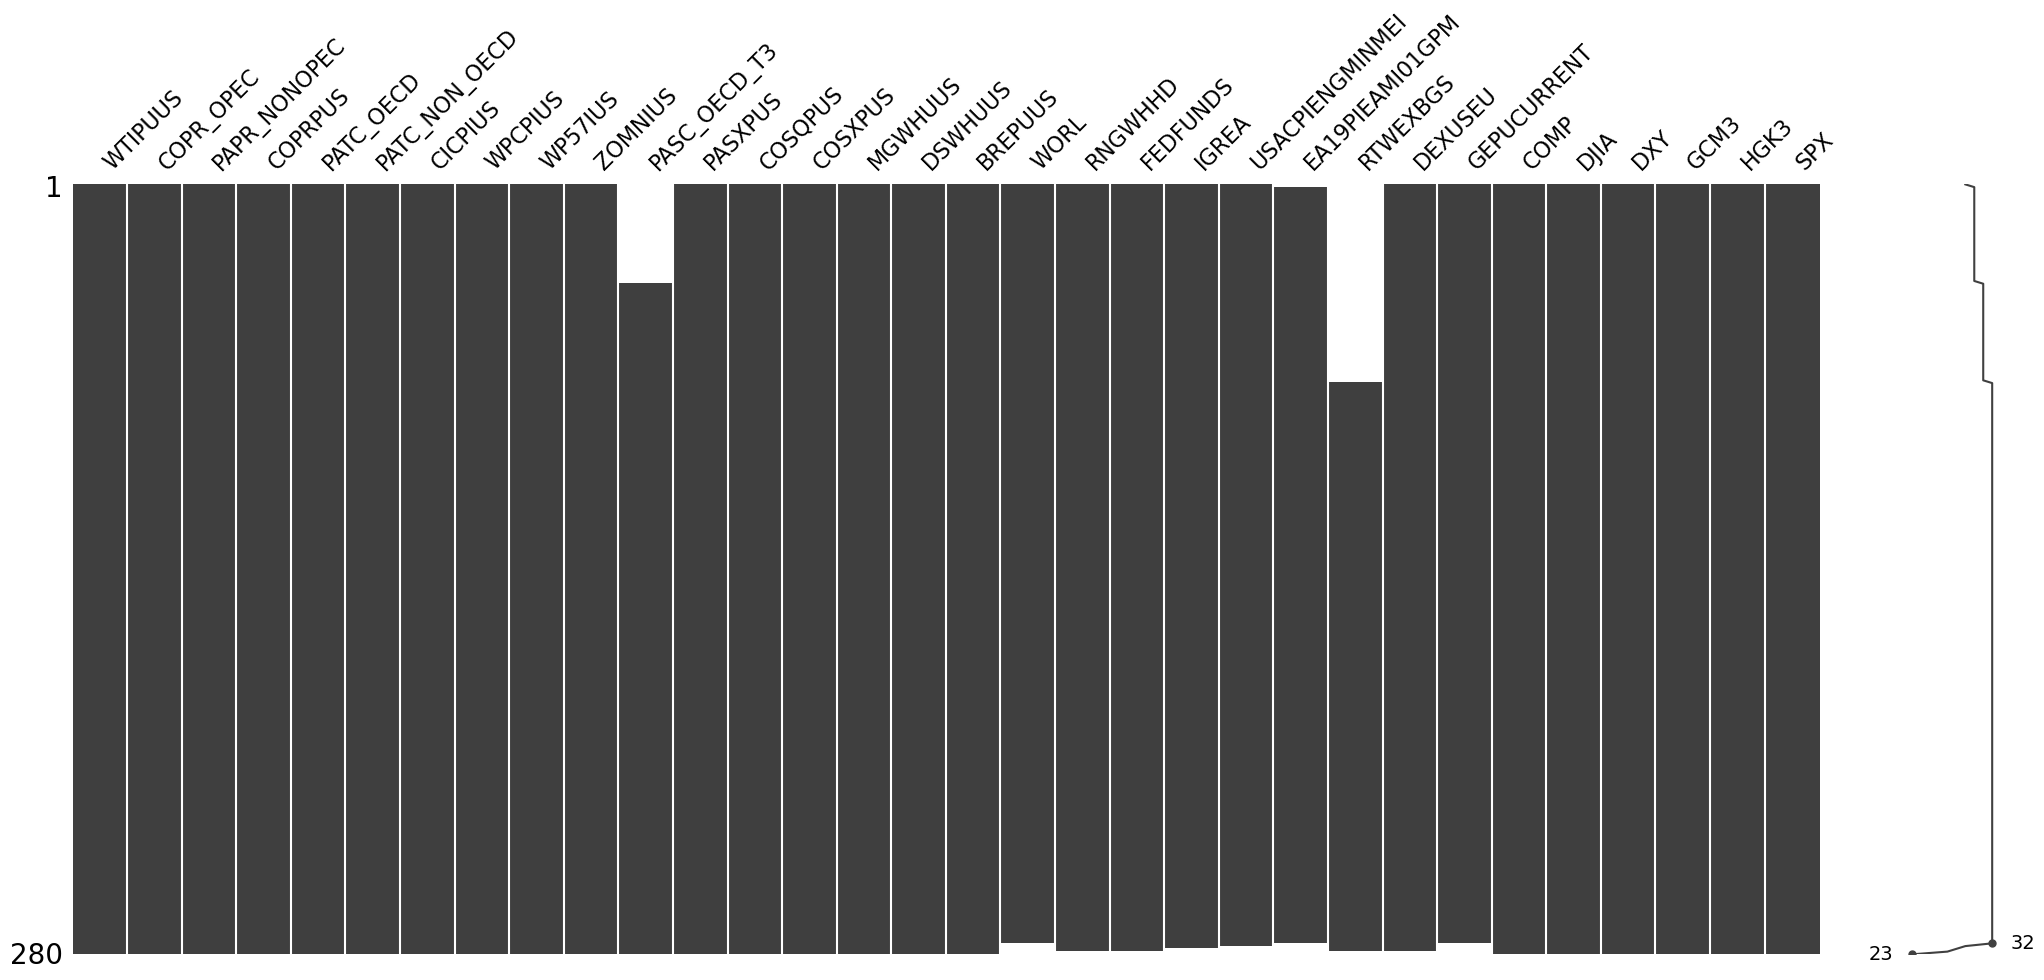

In [17]:
#Visualize the missing datausing "missingno" library
msno.matrix(df)
plt.show()

## Treat missing data

### 1. Set tolerances

In [18]:
### Tolerance for missing data %

print("""
Drop Columns:\t missing data (%) > tolerance_drop 
Drop Rows:\t tolerance_impute < missing data (%) < tolerance_drop
Impute Data:\t missing data (%) < tolerance_impute
""")

tolerance_drop = 10
tolerance_impute = 1

print('tolerance_drop =', tolerance_drop)
print('tolerance_impute =', tolerance_impute)


Drop Columns:	 missing data (%) > tolerance_drop 
Drop Rows:	 tolerance_impute < missing data (%) < tolerance_drop
Impute Data:	 missing data (%) < tolerance_impute

tolerance_drop = 10
tolerance_impute = 1


### 2. Drop Columns

#### Columns with NaN to drop

It is recommended to drop the  other data sources for the following featuers with more than the missing tolerance %

In [19]:
print('Columns with NaN to drop:')
drop_criteria = missing_stats['%'] > tolerance_drop 
columns_to_drop = missing_stats.loc[drop_criteria]
display(columns_to_drop.round(2))

Columns with NaN to drop:


,count,%
PASC_OECD_T3,36,12.86
RTWEXBGS,73,26.07


#### Drop column and store

In [20]:
#drop select columns
dropped_col = df.drop(columns = columns_to_drop.index, inplace = False)

print('Original data:',df.shape)
print('Missing droppped:', dropped_col.shape)

Original data: (280, 32)
Missing droppped: (280, 30)


### 3. Impute missing data

In [21]:
print('Columns with NaN to impute:')
impute_criteria = missing_stats['%'] < tolerance_impute
columns_to_impute = missing_stats.loc[impute_criteria]
display(columns_to_impute.round(2))

Columns with NaN to impute:


,count,%
RNGWHHD,1,0.36
FEDFUNDS,1,0.36
IGREA,2,0.71
DEXUSEU,1,0.36


#### Plot where data is missiing

In [22]:
def plot_timeseries(df, target_feature):
    
    #Plot the target feature
    fig, ax = plt.subplots(figsize = (8,2))
    
    #line plot for target feature
    sns.lineplot(data = df, x = df.index, y = target_feature)

    #scatter plot for missing values
    df_nan = df.loc[df[target_feature].isnull()]
    #use medain value for y
    y_val = df[target_feature].median()    
    sns.scatterplot(data = df_nan, x =df_nan.index, y = y_val, marker="o", color="r")

    # assign locator and formatter for the xaxis ticks.
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # put the labels at 45deg since they tend to be too long
    fig.autofmt_xdate()
    
    plt.show()

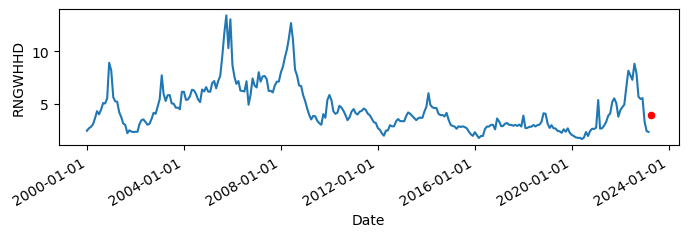

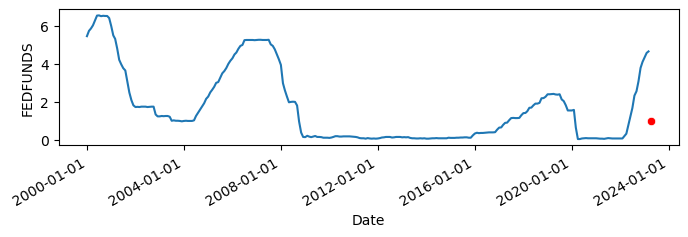

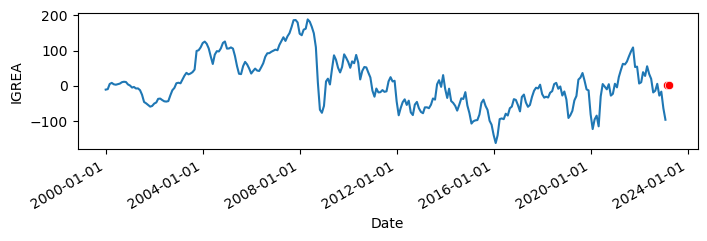

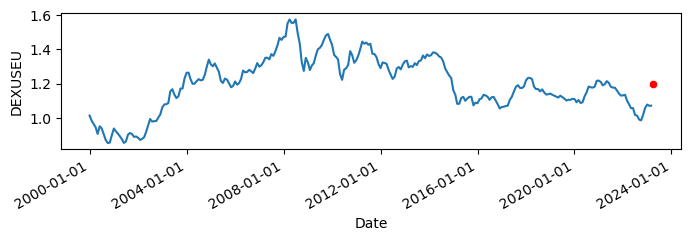

[None, None, None, None]

In [23]:
#plot the data and the missing data locatin 'TO BE IMPUTED'
[plot_timeseries(dropped_col, item) for item in columns_to_impute.index]

In [24]:
#Impute using bfill & ffil
for item in columns_to_impute.index:
    # Ffill imputation
    dropped_col[item] = dropped_col[item].fillna(method='ffill')
    # Bfill imputation
    dropped_col[item] = dropped_col[item].fillna(method='bfill')

In [25]:
print('Missing imputed:', dropped_col.shape)

Missing imputed: (280, 30)


### Drop Rows

In [26]:
#Count missing data
missing_stats = count_missing(dropped_col)

In [27]:
print('Columns with NaN to drop row:')
display(missing_stats.round(2))

Columns with NaN to drop row:


,count,%
WORL,4,1.43
USACPIENGMINMEI,3,1.07
EA19PIEAMI01GPM,5,1.79
GEPUCURRENT,4,1.43


In [28]:
dropped_row = dropped_col.dropna(axis = 0, inplace = False)

In [29]:
print('Missing droppped:', dropped_row.shape)

Missing droppped: (275, 30)


### Use df with no NaNs

In [30]:
df = dropped_row

## Explore data

### Check final DataFrame

In [31]:
#Display df head and tail
display(df.tail(7).T)

Date,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
WTIPUUS,114.840000,101.620000,93.670000,84.260000,87.550000,84.370000,76.440000
COPR_OPEC,28.300000,28.520000,29.530000,29.650000,29.195000,28.730000,28.820000
PAPR_NONOPEC,65.340897,66.283659,65.892938,66.115216,66.739481,67.146856,65.664137
COPRPUS,11.797257,11.844011,12.002495,12.337328,12.416878,12.379263,12.114716
PATC_OECD,46.333224,46.362408,47.017000,46.508033,45.434557,46.380107,46.143664
PATC_NON_OECD,54.307283,53.615062,53.539581,54.160522,52.748957,53.744647,54.782333
CICPIUS,2.947280,2.946280,2.953200,2.965390,2.979870,2.985980,2.989900
WPCPIUS,2.740642,2.710093,2.698021,2.680926,2.663334,2.632796,2.593839
WP57IUS,4.667990,4.064010,3.544670,3.607190,3.812240,3.626130,2.856720
ZOMNIUS,100.464500,100.734500,100.942700,101.140200,101.205500,100.501900,98.619900


### Traget feature

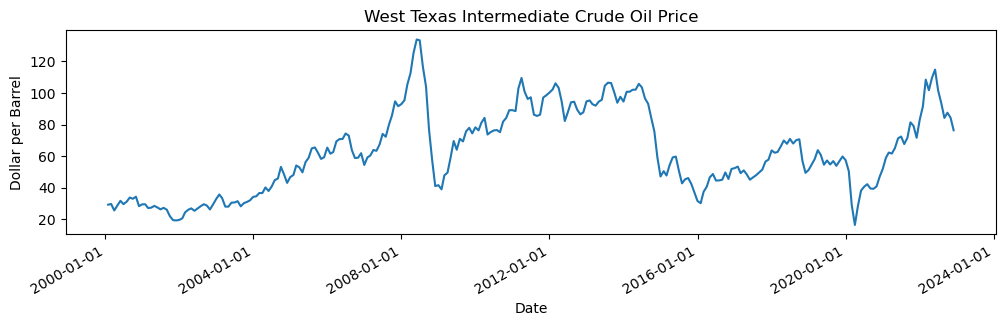

In [32]:
#Plot the target feature
fig, ax = plt.subplots(figsize = (12,3))
sns.lineplot(data = df, x = df.index, y = 'WTIPUUS').set(ylabel = 'Dollar per Barrel', title = 'West Texas Intermediate Crude Oil Price')

# assign locator and formatter for the xaxis ticks.
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# put the labels at 45deg since they tend to be too long
fig.autofmt_xdate()

plt.show()

### Summary Statistics

In [33]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
WTIPUUS,275.0,62.61,26.01,16.55,41.42,59.28,84.26,133.88
COPR_OPEC,275.0,29.03,1.94,22.35,28.20,29.28,30.37,32.39
PAPR_NONOPEC,275.0,55.88,6.05,46.62,50.92,54.53,60.90,67.46
COPRPUS,275.0,7.55,2.55,3.97,5.47,5.89,9.48,13.00
PATC_OECD,275.0,47.46,2.32,34.99,46.17,47.41,48.94,52.88
PATC_NON_OECD,275.0,42.30,8.42,28.13,34.33,43.11,50.25,54.78
CICPIUS,275.0,2.23,0.31,1.70,1.98,2.25,2.44,2.99
WPCPIUS,275.0,1.83,0.32,1.29,1.64,1.88,2.02,2.74
WP57IUS,275.0,1.98,0.81,0.59,1.38,1.93,2.56,4.67
ZOMNIUS,275.0,97.05,4.86,79.94,93.53,98.76,100.27,106.42


### Histograms

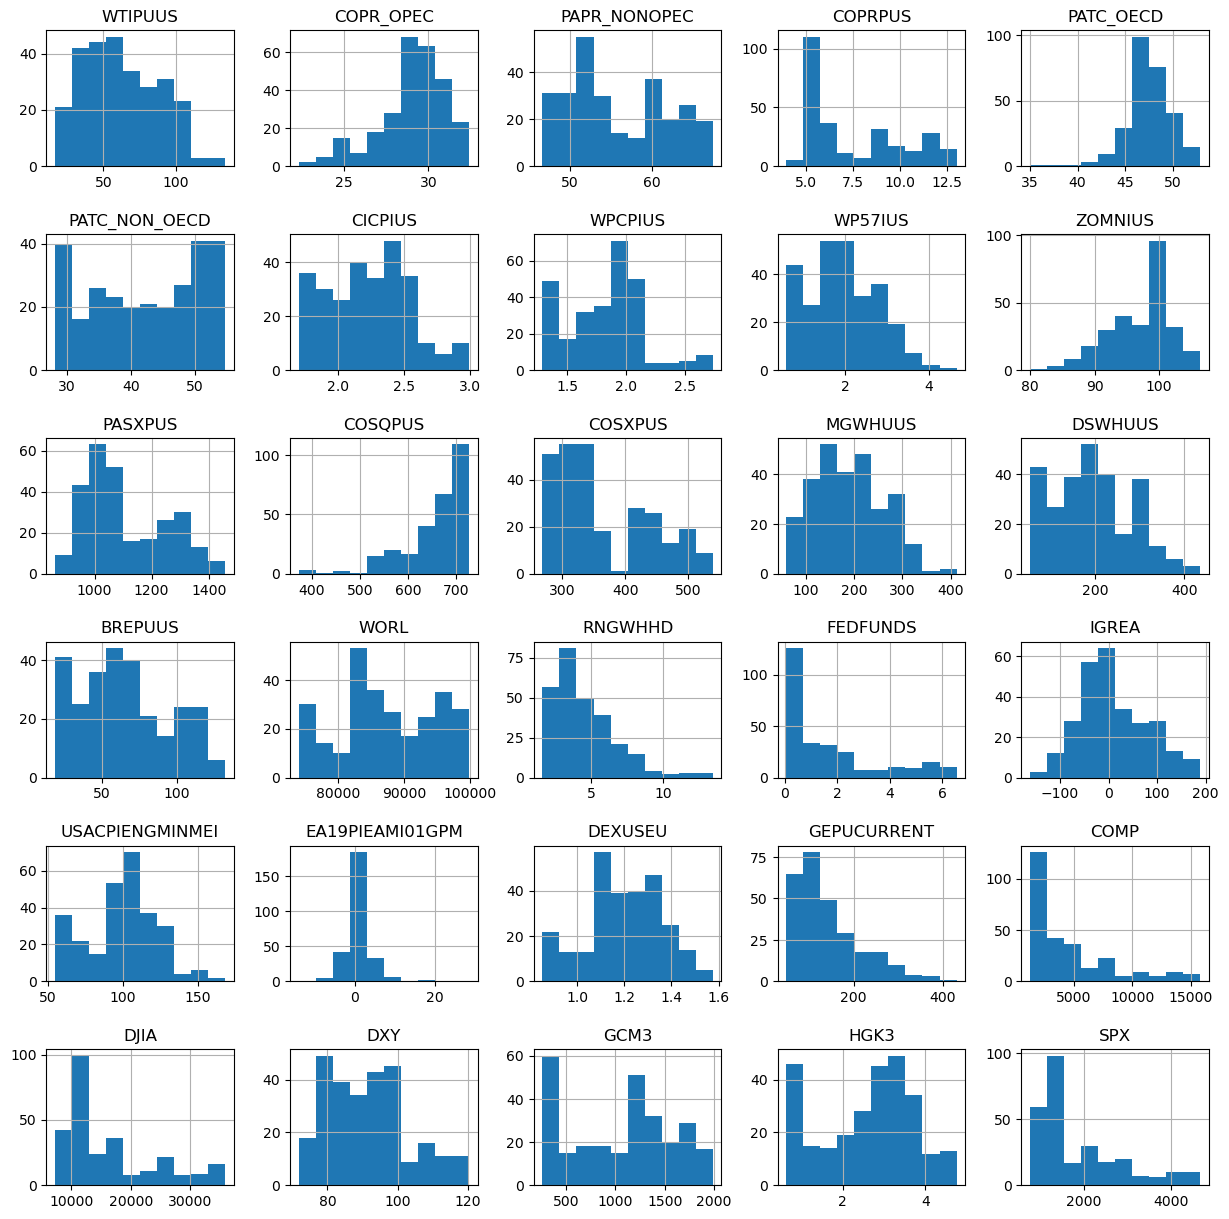

In [34]:
#Plot histogram of all  features
#Call plt.subplots_adjust() with an argument hspace=0.5 to adjust the spacing
#It's important you create legible and easy-to-read plots
df.hist(figsize=(15,15))
plt.subplots_adjust(hspace=0.5);


## Store data

In [36]:
# Change direcotry to the 'data\raw' folder
path = ROOT_DIR + '\\data\\interim\\'

# Set a file name
file_save = path + 'step2_data_wrangling.csv'
df.to_csv(file_save)

print('Save:\n', file_save)

Save:
 D:\gitProjects\WTI_Crude_Oil_Price_Prediction_Using_ML\data\interim\step2_data_wrangling.csv
